# Imports

In [197]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics.pairwise import cosine_similarity

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import matplotlib.cm as cm
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from IPython.display import clear_output
import random
import warnings
warnings.filterwarnings('ignore')

from transformers import (AutoModel, AutoTokenizer,
                          AutoModelForSequenceClassification)
from transformers import (RobertaTokenizer, RobertaModel, get_cosine_schedule_with_warmup)


# Utils

In [109]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything()

# Prepare data

## Reddit dataset user-text

In [110]:
data_path = 'reddit-dataset'
data = None
for file in os.listdir(data_path):
    if os.path.splitext(file)[1] == '.csv':
        df = pd.read_csv(os.path.join(data_path, file))
#         print (df)
        
        if 'entertainment' in os.path.splitext(file)[0] and len(df.columns)==13:
            df.drop([
                df.columns[0], df.columns[1], df.columns[3], df.columns[6],
                df.columns[8], df.columns[9], df.columns[10],
                df.columns[11], df.columns[12]], axis=1, inplace=True)
        else:
            df.drop([
                df.columns[0], df.columns[2], df.columns[5],
                df.columns[7], df.columns[8], df.columns[9],
                df.columns[10], df.columns[11]], axis=1, inplace=True)
            
        df=df.rename(columns = {
            df.columns[0]:'text', 
            df.columns[1]: 'subreddit', 
            df.columns[2]: 'meta', 
            df.columns[3]: 'name'})    
        
        
        df = df.loc[df['text'].notnull()]
        df['text'] = pd.Series(df['text'], dtype="string")
        df = df.loc[df.name != "[deleted]"]
        df = df.reset_index(drop=True)

        if data is None:
            data = df
        else:
            data = pd.concat([data, df], ignore_index=True)

In [111]:
data['name'] = data['name'].apply(func=lambda x: str(x))
data = data.sort_values('name').drop_duplicates().reset_index(drop=True)

In [112]:
data = data[data['meta'] != '3']

## Reddit dataset user-theme

In [113]:
data_path = 'archive'
df = pd.read_csv(os.path.join(data_path, 'reddit_data.csv'))

In [114]:
usernames_1 = set(df['username'])
usernames_2 = set(data['name'])
names = set.intersection(usernames_1, usernames_2)
data = data[data['name'].isin(names)].reset_index(drop=True)
df = df[df['username'].isin(names)].reset_index(drop=True)

In [115]:
df_all_labels = df
df = df[df['subreddit'].isin(set(data['subreddit']))]

df

,username,subreddit,utc
13,Esstand,pokemon,1.482724e+09
33,Esstand,pokemon,1.482475e+09
44,Esstand,pokemon,1.481991e+09
45,Esstand,pokemon,1.481990e+09
61,Esstand,pokemon,1.481614e+09
...,...,...,...
823454,RobotSnake,anime,1.474716e+09
823455,RobotSnake,skyrim,1.474678e+09
823456,RobotSnake,skyrim,1.474678e+09
823465,RobotSnake,skyrim,1.474383e+09


In [116]:
sums = df.groupby(by = 'username').count()['subreddit'].reset_index().rename(columns = {'subreddit': 'sum'})
df = df.merge(sums, left_on='username', right_on='username').reset_index(drop = True)

counts = df.groupby(by = ['username', 'subreddit']).count()['sum'].reset_index().rename(columns = {'sum': 'count'})
df = df.merge(counts, left_on='username', right_on='username').reset_index(drop = True)
df.drop(['subreddit_x', 'utc'], axis=1, inplace=True)
df = df.rename(columns = {'subreddit_y': 'subreddit'})

df['prob'] = df['count']/ df['sum']
df = df.drop_duplicates().reset_index(drop = True)
df

,username,sum,subreddit,count,prob
0,Esstand,8,pokemon,8,1.000000
1,refugefirstmate,172,news,61,0.354651
2,refugefirstmate,172,worldnews,111,0.645349
3,Goodkat203,721,askscience,11,0.015257
4,Goodkat203,721,funny,3,0.004161
...,...,...,...,...,...
6084,RobotSnake,179,gaming,11,0.061453
6085,RobotSnake,179,pokemon,11,0.061453
6086,RobotSnake,179,skyrim,50,0.279330
6087,RobotSnake,179,tf2,60,0.335196


In [117]:
sums = df_all_labels.groupby(by = 'username').count()['subreddit'].reset_index().rename(columns = {'subreddit': 'sum'})
df_all_labels = df_all_labels.merge(sums, left_on='username', right_on='username').reset_index(drop = True)

counts = df_all_labels.groupby(by = ['username', 'subreddit']).count()['sum'].reset_index().rename(columns = {'sum': 'count'})
df_all_labels = df_all_labels.merge(counts, left_on='username', right_on='username').reset_index(drop = True)
df_all_labels.drop(['subreddit_x', 'utc'], axis=1, inplace=True)
df_all_labels = df_all_labels.rename(columns = {'subreddit_y': 'subreddit'})

df_all_labels['prob'] = df_all_labels['count']/ df_all_labels['sum']
df_all_labels = df_all_labels.drop_duplicates().reset_index(drop = True)
df_all_labels

,username,sum,subreddit,count,prob
0,Esstand,1000,AskReddit,2,0.002000
1,Esstand,1000,DotA2,589,0.589000
2,Esstand,1000,GetMotivated,1,0.001000
3,Esstand,1000,Warframe,11,0.011000
4,Esstand,1000,darksouls3,17,0.017000
...,...,...,...,...,...
55885,RobotSnake,996,todayilearned,1,0.001004
55886,RobotSnake,996,totallynotrobots,1,0.001004
55887,RobotSnake,996,trypophobia,1,0.001004
55888,RobotSnake,996,unitedkingdom,5,0.005020


In [118]:
data

,text,subreddit,meta,name
0,ok so that means owning people is ok,facepalm,humor,10art1
1,sounds like a good deal to me mashed potatoes ...,facepalm,humor,10art1
2,thats one way to make sure they never get a job,facepalm,humor,10art1
3,why would you shop at tesco anyways,facepalm,humor,10art1
4,and north korea is a democratic republic,facepalm,humor,10art1
...,...,...,...,...
1531,whispering bluffs confirmed,gaming,gaming,zgh5002
1532,one good ski pole swing to the neck and that b...,funny,humor,zpridgen75
1533,male privilege,news,news,zstansbe
1534,i m sure the justice department will be puttin...,news,news,zstansbe


In [119]:
max_len = 64
overlap = 0
cnt = 0
data_1 = data.copy()
for (i,r) in data_1.iterrows():
#     print (len(r))
    words = r['text'].split(' ')
    if len(words) > max_len:
        for p in range(0, len(words), max_len- overlap):
            new_r = r.copy()
            new_r['text'] = ' '.join(words[p:p + max_len])
            
            if new_r['text'].strip() != '':
                data_1 = data_1.append(new_r)
        cnt += 1
        data_1.reset_index(drop=True, inplace=True)
        data_1.drop(i, inplace=True)
print (cnt)

335


In [120]:
data = data_1 

# Make features from text

In [121]:
labels = LabelEncoder()
labels.fit(data['subreddit'])
y = labels.transform(data['subreddit'])
data['subreddit_labels'] = y

In [122]:
df['subreddit_labels'] = labels.transform(df['subreddit'])

In [123]:
data

,text,subreddit,meta,name,subreddit_labels
0,ok so that means owning people is ok,facepalm,humor,10art1,14
1,sounds like a good deal to me mashed potatoes ...,facepalm,humor,10art1,14
2,thats one way to make sure they never get a job,facepalm,humor,10art1,14
3,why would you shop at tesco anyways,facepalm,humor,10art1,14
4,and north korea is a democratic republic,facepalm,humor,10art1,14
...,...,...,...,...,...
2334,from government s memorandum in support of i...,news,news,yhwhx,33
2335,they were enforcing federal court orders near...,news,news,yhwhx,33
2336,gt gt bundy is currently charged with crime...,news,news,yhwhx,33
2337,usc 3142 e 3 b here no evidence has b...,news,news,yhwhx,33


In [124]:
unique_names = data['name'].unique()
# Take ~20% of unique names
test_names = random.sample(list(unique_names),len(unique_names) // 5)

In [125]:
data_test = data[data['name'].isin(test_names)].reset_index(drop=True)

In [126]:
data = data[~data['name'].isin(test_names)].reset_index(drop=True)

In [127]:
data

,text,subreddit,meta,name,subreddit_labels
0,ok so that means owning people is ok,facepalm,humor,10art1,14
1,sounds like a good deal to me mashed potatoes ...,facepalm,humor,10art1,14
2,thats one way to make sure they never get a job,facepalm,humor,10art1,14
3,why would you shop at tesco anyways,facepalm,humor,10art1,14
4,and north korea is a democratic republic,facepalm,humor,10art1,14
...,...,...,...,...,...
1927,i have ever seen this is not a conservative o...,politics,news,waalchastazoor,36
1928,you re easier to control you can put any spin ...,politics,news,waalchastazoor,36
1929,is the last thing they consider i think the c...,politics,news,waalchastazoor,36
1930,you can only offer something for free if you l...,news,news,yes_its_him,33


In [128]:
data_test

,text,subreddit,meta,name,subreddit_labels
0,i want a full good version of the bear and the...,gameofthrones,television,ACrusaderA,18
1,aegon blackfyre,gameofthrones,television,ACrusaderA,18
2,secret door at the night fort,gameofthrones,television,ACrusaderA,18
3,i would like longclaw it s plain it s elegan...,gameofthrones,television,ACrusaderA,18
4,tyrion traveled to castle black the door is a...,gameofthrones,television,ACrusaderA,18
...,...,...,...,...,...
401,from government s memorandum in support of i...,news,news,yhwhx,33
402,they were enforcing federal court orders near...,news,news,yhwhx,33
403,gt gt bundy is currently charged with crime...,news,news,yhwhx,33
404,usc 3142 e 3 b here no evidence has b...,news,news,yhwhx,33


In [129]:
df.to_csv('df.csv', index=False)
df_all_labels.to_csv('df_all_labels.csv', index=False)
data.to_csv('data.csv', index=False)
data_test.to_csv('data_test.csv', index=False)

# Prediction

## Roberta

### Model

In [130]:
df = pd.read_csv('df.csv')
df_all_labels = pd.read_csv('df_all_labels.csv')
data = pd.read_csv('data.csv')
data_test = pd.read_csv('data_test.csv')

In [23]:
class CustomDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_len):
        self.comments = X
        self.targets = y
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        encode = self.tokenizer(self.comments[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
    
        target = torch.tensor(self.targets[idx]).type(torch.LongTensor)
        return encode, target

    def __len__(self):
        return len(self.comments)

In [24]:
class AttentionHead(nn.Module):
    def __init__(self, in_features, hidden_dim):
        super(AttentionHead, self).__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim

        self.W = nn.Linear(in_features, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.out_features = hidden_dim

        self.init_weights(self.W, self.V)

    def init_weights(self, *blocks):
        for m in blocks:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, features):
        att = torch.tanh(self.W(features))

        score = self.V(att)

        attention_weights = torch.softmax(score, dim=1)

        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector

In [25]:
class Model(nn.Module):
    def __init__(self, n_classes):
        super(Model, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base', output_hidden_states = True)
        self.head = AttentionHead(768, 768)

        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(self.head.out_features, n_classes)

        self.init_weights(self.linear)
        # self.freeze_layers()

    def freeze_layers(self):
        modules = [self.roberta.embeddings, *self.roberta.encoder.layer[:5]]
        for module in modules:
            for param in module.parameters():
                param.requires_grad = False

    def init_weights(self, *blocks):
        for m in blocks:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, **xb):
        # print (self.roberta(**xb)[2][0].shape, len(self.roberta(**xb)[2]))
        x = self.roberta(**xb)[0]

        # [b_layers, batch_size, max_len, features]
#         x = self.roberta(**xb)[2]

        # [batch_size, k * max_len, features]
#         x = torch.cat(x, dim=1)

        attn = self.head(x)
        x = self.dropout(attn)
        x = self.linear(x)
        return x, attn

In [26]:
class BertTrainer:
    def __init__(self, args, model, optimizer, train_loader, test_loader):
        self.__dict__ = args
        self.model = model
        self.optimizer = optimizer

        self.lr_scheduler = get_cosine_schedule_with_warmup(
            self.optimizer, num_warmup_steps=self.warmup, num_training_steps=self.epochs * len(train_loader))
        # self.lr_scheduler = None

        self.train_loader = train_loader
        self.test_loader = test_loader

        self.writer = SummaryWriter(
            log_dir=args.summary_dir if self.logdir != '' else None)
        self.best_test_loss = 999999
        
        self.train_history = []
        self.test_history = []

    def resume_training(self):
        if os.path.isfile(self.resume):
            print("=> loading checkpoint '{}'".format(self.resume))
            checkpoint = torch.load(self.resume)
            self.start_epoch = checkpoint['epoch']
            self.best_test_loss = checkpoint['best_test_loss']
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(self.resume, checkpoint['epoch']))

    def save_checkpoint(self, epoch, filename='checkpoint.pth.tar'):
        save_dir = self.save_dir
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)

        state = {
                'epoch': epoch,
                'state_dict': self.model.state_dict(),
                'best_test_loss': self.best_test_loss,
                'optimizer': self.optimizer.state_dict(),
            }
        torch.save(state, os.path.join(save_dir, filename))
        print (f"Saved if {os.path.join(save_dir, filename)}")

    def loss_fn(self, outputs, targets):
#         outputs = outputs.view(-1)
#         targets = targets.view(-1)
        return nn.CrossEntropyLoss()(outputs, targets)

    def train(self):
        with tqdm(desc="Epoch", total=self.epochs) as progress:
            for epoch in range(self.epochs):
                self.train_epoch(epoch)

                progress.update(1)

    def adjust_lr(self, i):
        lr = self.lr * (self.lr_coef ** ((i + 1) // self.lr_interval))
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

    def train_epoch(self, epoch):
        train_losses = []
        for i, (X_batch, y_batch) in enumerate(self.train_loader):
            self.model.train()
            self.optimizer.zero_grad()

            inputs = {key: val.reshape(val.shape[0], -1).to(self.device) for key, val in X_batch.items()}
            y_pred, xrb = self.model(**inputs)

            loss = self.loss_fn(y_pred, y_batch.to(self.device))
            loss.backward()

            counter = epoch * len(self.train_loader) + i

            self.optimizer.step()
            if self.lr_change == 'scheduler':
                self.lr_scheduler.step()
            elif self.lr_change == 'adjust':
                self.adjust_lr(counter)

            train_losses.append(loss.item())

            # Logging

            if ((i % self.valid_step == 0) or (i+1) == len(self.train_loader)):
                eval_loss = self.evaluate()
                self.writer.add_scalar("Train loss", np.mean(train_losses), counter)
                self.writer.add_scalar("Test loss", eval_loss, counter)

                self.train_history.append(np.mean(train_losses))
                self.test_history.append(eval_loss)
                
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

                clear_output(True)
                ax[0].plot(train_losses, label='train loss')
                ax[0].set_xlabel('Batch')
                ax[0].set_title('Train loss')
                if self.train_history is not None:
                    ax[1].plot(self.train_history, label='general train history')
                    ax[1].set_xlabel('Eval step')
                if self.test_history is not None:
                    ax[1].plot(self.test_history, label='general test history')
                plt.legend()
            
                plt.show()

                if eval_loss < self.best_test_loss:
                    self.best_test_loss = eval_loss
                    self.save_checkpoint(epoch)

                    print(f"Step {i}/{len(self.train_loader)} "
                          f"[Epoch {epoch}] Train loss: {np.mean(train_losses)} | "
                          f"[Epoch {epoch}] Validation loss: {eval_loss}")

    def evaluate(self):
        test_losses = []
        self.model.eval()
        with torch.no_grad():
            for i,(X_batch, y_batch) in enumerate(self.test_loader):

                inputs = {key: val.reshape(val.shape[0], -1).to(self.device) for key, val in X_batch.items()}

                y_pred, xrb = self.model(**inputs)
                loss = self.loss_fn(y_pred, y_batch.to(self.device))
                test_losses.append(loss.item())

        return np.mean(test_losses)

### Train

In [27]:
args = dotdict({
    'collab': False,
    'seed': 42,
    'logdir': 'runs',
    'checkpoint_dir': 'checkpoints',
    'model_name': 'RoBerta',
    'model_log_name': 'Model8',
    
    'batch_size': 16,
    'epochs': 10,
    'max_len': 256,
    'valid_step': 100,
    'lr': 2e-5,
    'warmup': 50,
    
    'lr_coef': 0.99,
    'lr_interval': 5,
    'lr_change': 'scheduler',
    'resume': '',
    })

# Checkpoints
args.save_dir = os.path.join(
    args.checkpoint_dir, os.path.join(args.model_name, args.model_log_name))
if not os.path.isdir(os.path.join(
        args.checkpoint_dir, os.path.join(args.model_name, args.model_log_name))):
    os.makedirs(os.path.join(
        args.checkpoint_dir, os.path.join(args.model_name, args.model_log_name)))

# Summary writer
args.summary_dir = os.path.join(args.logdir, args.model_log_name)
if not os.path.isdir(os.path.join(args.logdir, args.model_log_name)):
    os.makedirs(os.path.join(args.logdir, args.model_log_name))

args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (args.device)
seed_everything(seed=args.seed)    

cuda


In [28]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = Model(n_classes=len(data['subreddit_labels'].unique())).to(args.device)
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=0.01)

# X_train, X_test, y_train, y_test = train_test_split(data['text'].values, data['subreddit_labels'].values, 
#                                                     test_size=0.20, shuffle=True)
X_train = data['text'].values
X_test = data_test['text'].values

y_train = data['subreddit_labels'].values
y_test = data_test['subreddit_labels'].values

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
train_dataset = CustomDataset(X_train, y_train, tokenizer, args.max_len)
test_dataset = CustomDataset(X_test, y_test, tokenizer, args.max_len)

train_loader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=False
)

bert_trainer = BertTrainer(args, model, optimizer, train_loader, test_loader)

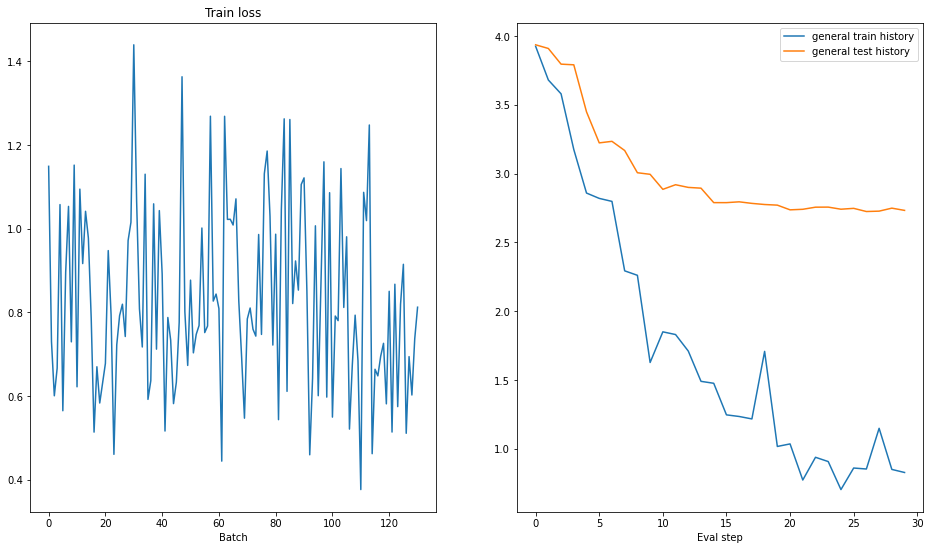

Epoch: 100%|███████████████████████████████████| 10/10 [19:45<00:00, 118.54s/it]


In [32]:
bert_trainer.train()

## Load and evaluate model

In [31]:
bert_trainer = BertTrainer(args, model, optimizer, train_loader, test_loader)
args.resume = 'checkpoints/RoBerta/Model7/checkpoint.pth.tar'
bert_trainer.resume_training()
model = bert_trainer.model

=> loading checkpoint 'checkpoints/RoBerta/Model8/checkpoint.pth.tar'
=> loaded checkpoint 'checkpoints/RoBerta/Model8/checkpoint.pth.tar' (epoch 7)


### Validation text-theme from Github dataset

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text = data_test['text'].values
target = data_test['subreddit_labels'].values

test_preds = []
for sentence in text:
    encode = tokenizer(sentence,
        return_tensors='pt',
        max_length=max_len,
        padding='max_length',
        truncation=True) 
    inputs = {key: value.reshape(value.shape[0], -1).to(device) for key, value in encode.items()}
    y_pred, _ = model(**inputs)
    y_pred = np.argmax(y_pred.detach().cpu().numpy())
    test_preds.append(y_pred)

In [34]:
from sklearn.metrics import f1_score
print ("F1 weighted", f1_score(target, test_preds, average='weighted'))

F1 weighted 0.3060719943221747


In [35]:
from sklearn.metrics import accuracy_score
print ("Accuracy score", accuracy_score(target, test_preds))

Accuracy score 0.3103448275862069


### Validation user-theme from Kaggle dataset as KL divergence using common subreddit themes

In [335]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

KL_s = []

for name in test_names:
    target_themes = df[df['username']==name]['subreddit_labels'].values
    target_themes = [x-1 for x in target_themes]
    
    text = data_test[data_test['name']==name]['text'].values

    test_preds = []
    for sentence in text:
        encode = tokenizer(sentence,
                                return_tensors='pt',
                                max_length=args.max_len,
                                padding='max_length',
                                truncation=True) 
        inputs = {key: value.reshape(value.shape[0], -1).to(device) for key, value in encode.items()}
        y_pred, _ = model(**inputs)    

        test_preds.append(torch.nn.functional.softmax(y_pred/2)[-1].detach().cpu().numpy())
    
    y_true = np.zeros(shape=(len(data['subreddit_labels'].unique()), ))
    y_true[target_themes] = df[df['username']==name]['prob'].values
    
    test_pred = np.mean(test_preds, axis=0)
    EPS = 1e-5
    KL = np.sum((y_true+EPS) * np.log((y_true+EPS)/(test_pred + EPS)))
#     print (y_true, test_pred)
    KL_s.append(KL)
print ("AVG KL divergence", np.mean(KL_s))

AVG KL divergence 3.045487426773145


### Cosine distance with all labels

In [293]:
roberta = RobertaModel.from_pretrained('roberta-base', output_hidden_states = True).to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [339]:
all_labels = df_all_labels['subreddit'].unique()
all_labels_encoded = []

for label in tqdm(all_labels):
    encode = tokenizer(label,
        return_tensors='pt',
        max_length=16,
        padding='max_length',
        truncation=True)
    inputs = {key: value.reshape(value.shape[0], -1).to(device) for key, value in encode.items()}
#     y_pred, roberta_layers = model(**inputs)
    roberta_layers = roberta(**inputs)[2][0].detach().cpu().numpy()
    roberta_layers = np.hstack(roberta_layers[0])
    all_labels_encoded.append(roberta_layers)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8815/8815 [01:09<00:00, 127.27it/s]


In [340]:
labels = data['subreddit'].unique()
labels_encoded = []

for label in tqdm(labels):
    encode = tokenizer(label,
        return_tensors='pt',
        max_length=16,
        padding='max_length',
        truncation=True) 
    inputs = {key: value.reshape(value.shape[0], -1).to(device) for key, value in encode.items()}
#     y_pred, roberta_layers = model(**inputs)
    roberta_layers = roberta(**inputs)[2][0].detach().cpu().numpy()
    roberta_layers = np.hstack(roberta_layers[0])
    labels_encoded.append(roberta_layers)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 122.34it/s]


In [341]:
all_labels_dict = {word: emb for word, emb in zip(df_all_labels['subreddit'].unique(),all_labels_encoded)}
labels_dict = {word: emb for word, emb in zip(data['subreddit'].unique(),labels_encoded)}

In [342]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cos = 0.8
IOU_s = []
for name in tqdm(test_names):    
    text = data_test[data_test['name']==name]['text'].values

    pred_themes = []
    for sentence in text:
        encode = tokenizer(sentence,
                                return_tensors='pt',
                                max_length=args.max_len,
                                padding='max_length',
                                truncation=True) 
        inputs = {key: value.reshape(value.shape[0], -1).to(device) for key, value in encode.items()}
        y_pred, _ = model(**inputs)    

        probs = torch.nn.functional.softmax(y_pred)[-1].detach().cpu().numpy()
        
        pred_theme = data['subreddit'].unique()[np.argmax(probs)]
        cosines = cosine_similarity(all_labels_encoded, labels_dict[pred_theme].reshape(1, -1))
        
        cosines[cosines < cos] = 0
        top_k = sum(np.array(cosines != 0))[-1]
        idx = np.argsort(cosines, axis=0)[::-1]
        closest = df_all_labels['subreddit'].unique()[idx][:top_k]
        
        targets = df_all_labels[df_all_labels['username']==name]['subreddit'].values
        closest = [x[-1] for x in closest]
        pred_themes.extend(closest)
    
    true_themes = sorted(list(zip(
        targets,
        df_all_labels[df_all_labels['username']==name]['prob'].values)), key=lambda x: x[1], reverse=True)
    IOU = len(set.intersection(set(pred_themes), set(targets)))/len(set.union(set(pred_themes), set(targets)))
    IOU_s.append(IOU)
print ("Mean IOU:", np.mean(IOU_s))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [02:15<00:00,  1.15it/s]

Mean IOU: 0.00815570876690987


# Simple example to show subreddit class imbalance and misproportionality in github and kaggle dataset

In [358]:
test_names

['ravia',
 'Eponarose',
 'Archimid',
 'zedoktar',
 'PostcardPoet',
 'Neanderthal_Gene',
 'Male_strom',
 'Gifibidy',
 'yhwhx',
 'Durbee',
 'spongebob_meth',
 'yungtatha',
 'immaculate_deception',
 'Dezzy-Bucket',
 'mcreeves',
 'ZehuaLin',
 'AudibleNod',
 'At_Work_SND_Coffee',
 'Donners22',
 'MQ2000',
 'Milith',
 'enoughdakka',
 'mrlr',
 'AskScienceModerator',
 'ka36',
 'LOTM42',
 'vetro',
 'rtyuuytr',
 'timmycosh',
 'AssaultMode',
 'Yum_Kaax',
 'MaXKiLLz',
 'bellsofwar3',
 'maverick1470',
 'Pun_In_Ten_Did',
 'ACrusaderA',
 'IDoNotAgreeWithYou',
 'thesynod',
 'zuperpailon',
 'SuperFreddy',
 'workpuppy',
 'Heigou',
 'LoveCandiceSwanepoel',
 'Starterjoker',
 'RobKhonsu',
 'Donald-Trumps-Hair',
 'ThundercuntIII',
 'DrDeth666',
 'TheBestBarista',
 'SuperSovereignty',
 'myairblaster',
 'OriginalPostSearcher',
 'BoneZoneAlone',
 'bruvar',
 'hodyoaten',
 'Flyberius',
 'Thr33St0r13s',
 'Darkchyylde',
 'jak0b345',
 'Roborabbit37',
 'plantspants',
 'onnowhere',
 'TheEpicGreenMask',
 'loki8481',
 '

In [378]:
name = 'TommBomBadil'
text = data_test[data_test['name']==name]['text'].values
cos_s = []
for sentence in text:
    encode = tokenizer(sentence,
                            return_tensors='pt',
                            max_length=args.max_len,
                            padding='max_length',
                            truncation=True) 
    inputs = {key: value.reshape(value.shape[0], -1).to(device) for key, value in encode.items()}
    y_pred, _ = model(**inputs)    
    probs = torch.nn.functional.softmax(y_pred)[-1].detach().cpu().numpy()
    
    pred_theme = data['subreddit'].unique()[np.argmax(probs)]
    cosines = cosine_similarity(all_labels_encoded, labels_dict[pred_theme].reshape(1, -1))
    cosines[cosines < cos] = 0
    top_k = sum(np.array(cosines != 0))[-1]
    idx = np.argsort(cosines, axis=0)[::-1]
    
    closest = df_all_labels['subreddit'].unique()[idx][:top_k]
        
    targets = df_all_labels[df_all_labels['username']==name]['subreddit'].values
    closest = [x[-1] for x in closest]
    
    true_themes = sorted(list(zip(
        targets,
        df_all_labels[df_all_labels['username']==name]['prob'].values)), key=lambda x: x[1], reverse=True)
    true_themes = [x[0] for x in true_themes]

In [379]:
true_themes

['EnoughTrumpSpam',
 'AdviceAnimals',
 'RoastMe',
 'RetroFuturism',
 'worldnews',
 'Libertarian',
 'OldSchoolCool',
 'gifs',
 'worldpolitics',
 'ImaginaryMonsters',
 'Watches',
 'boston',
 'news',
 'BirdsForScale',
 'PoliticalHumor',
 'pics',
 'libertarianmeme',
 'gentlemanboners',
 'uberdrivers',
 'ImaginaryBeasts',
 'RoomPorn',
 'Whiskyporn',
 'evilbuildings',
 'Art',
 'papertowns',
 'AskWomen',
 'Celebs',
 'MotorcyclePorn',
 'PerfectTiming',
 'PropagandaPosters',
 'StarWars',
 'CombatFootage',
 'ImaginaryBehemoths',
 'ImaginaryTechnology',
 'holdmyredbull',
 'oddlysatisfying',
 'politics',
 'retrobattlestations',
 'ExpectationVsReality',
 'HistoryPorn',
 'IdiotsFightingThings',
 'ImaginaryHorrors',
 'askphilosophy',
 'movies',
 'ImaginaryMindscapes',
 'OnOff',
 'UpliftingNews',
 'changemyview',
 'dashcamgifs',
 'thalassophobia',
 'uncensorednews',
 'AccidentalRenaissance',
 'AskMen',
 'DestructionPorn',
 'Drumpf',
 'Futurology',
 'Infographics',
 'OldSchoolCoolNSFW',
 'PrettyGirls',

In [385]:
closest

['sex',
 'species',
 'gay',
 'women',
 'food',
 'science',
 'smoking',
 'sleep',
 'jobs',
 'help',
 'community',
 'sports',
 'folk',
 'suits',
 'language',
 'it',
 'psych',
 'biology',
 'Britain',
 'media',
 'css',
 'see',
 'dating',
 'news',
 'chrome',
 'environment',
 'cancer',
 'legal',
 'netflix',
 'climate',
 'moving',
 'education',
 'wikipedia',
 'vim',
 'nuclear',
 'politics',
 'history',
 'meat',
 'business',
 'driving',
 'tumblr',
 'travel',
 'medical',
 'terrorism',
 'law',
 'microsoft',
 'linux',
 'California',
 'technology',
 'rock',
 'videos',
 'codes',
 'rage',
 'ask',
 'acting',
 'nes',
 'canon',
 'happy',
 'tax',
 'tech',
 'flying',
 'country',
 'punk',
 'cars',
 'coins',
 'energy',
 'lux',
 'test',
 'water',
 'raining',
 'gaming',
 'VPN',
 'wow',
 'string',
 'nutrition',
 'engineering',
 'alcohol',
 'ass',
 'dogs',
 'everything',
 'anything',
 'windows',
 'college',
 'beer',
 'security',
 'software',
 'writing',
 'cpp',
 'vic',
 'amazon',
 'tall',
 'ball',
 'deals',
 '

In [384]:
data_test[data_test['name']==name]

,text,subreddit,meta,name,subreddit_labels
130,enjoy it while you re young,sex,lifestyle,TommBomBadil,39


In [383]:
test_df = df_all_labels[df_all_labels['username'] == name]
test_df.sort_values('count')

,username,sum,subreddit,count,prob
36740,TommBomBadil,999,100yearsago,1,0.001001
36858,TommBomBadil,999,TumblrInAction,1,0.001001
36860,TommBomBadil,999,Unexpected,1,0.001001
36862,TommBomBadil,999,WWIIplanes,1,0.001001
36866,TommBomBadil,999,Watercolor,1,0.001001
...,...,...,...,...,...
36842,TommBomBadil,999,RetroFuturism,19,0.019019
36976,TommBomBadil,999,worldnews,19,0.019019
36843,TommBomBadil,999,RoastMe,28,0.028028
36744,TommBomBadil,999,AdviceAnimals,60,0.060060


Хочу написать пару слов о том, что вообще в этом ноутбуке происходит:
1) Учим классификатор, способный определять тему на реддите по комментарию, качество не очень, но и человек вряд-ли сможет показать результат лучше

2) Для каждого пользователя читаем его комментарии, предсказываем темы комментариев и ищем наиболее близкие к ним по смыслу среди всех остальных при помощи косинусного расстояния, метрику я выбрал Intersection over union т.к. можно оценить, насколько предскаазанное множество тем пересекается с таргетным

3) В пункте 5.2.2 я валидировал модель, принимая за таргеты распределение тем, которые пересекаются в датасете с гитхаба и в датасете с каггла, тоесть темы, которые входят в предсказываемые классы, измерял я похожесть распределения таргетного и выходного с модели при помощи KL дивергенции

4) Как можно было лучше придумать эмбеддинги для подсчета косинусного расстояния? Обучить классификатор субтемы и извлечь фичи из такой модели, но субтем в датасете каггла нет, поэтому я пользовался предбученным бертом